In [35]:
import numpy as np
import videos.perceptron as vp
import matplotlib.pyplot as plt
import math
import manim

Quite a lot of machine learning techniques can be viewed as an attempt to find a vector to represent some data. Once we find a vector to represent the data, we use it to convert each data point into a single number. 

From a high level perspective, we have available high-dimensional data points and we wish to convert each data point to a single number, and once we do, we can design simple rules, like `if x > 0, then class_1 else class_2`. 

Perceptrons, regression, support vector machines, and principal component analysis are examples of methods which can be viewed as searching for an appropriate vector, then projecting all data onto this vector. A single visualization can provide visual intuition for all of these methods.

You can find yourself reinventing famous machine learning methods if you give yourself a problem with the right constraints. Consider you are given the following data points. There are 14 data points in 2D Euclidean space. 

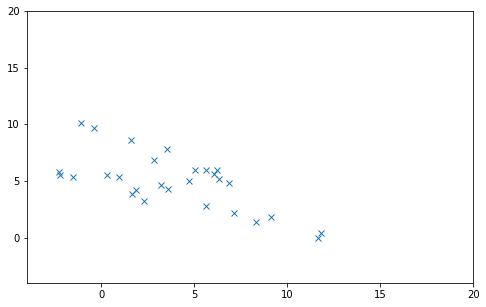

In [34]:
NUM_POINTS_PER_CLASS = 14
NUM_CLASSES = 2
NUM_POINTS = NUM_CLASSES * NUM_POINTS_PER_CLASS

def generate_data():
    seed = 124
    rng = np.random.Generator(np.random.PCG64(seed))
    def transform(points, rotate_rads, offset):
        scale = np.array([[0.5, 0], [0, 5.0]])
        rotate = np.array([[math.cos(rotate_rads), math.sin(rotate_rads)],
                           [-math.sin(rotate_rads), math.cos(rotate_rads)]])
        points = points @ scale
        points = points @ rotate
        points = points + offset
        return points
    points = rng.multivariate_normal([0,0], [[1, 0],[0,1]], size=NUM_POINTS)
    points_c1 = transform(points[:NUM_POINTS//2], 1.2, np.array([3, 4]))
    points_c2 = transform(points[NUM_POINTS//2:], 0.9, np.array([5, 6]))
    return np.concatenate([points_c1, points_c2], axis=0)

points = generate_data()
fig, ax = plt.subplots(figsize=(8,5))
ax.set_ylim([-4, 20])
ax.set_xlim([-4, 20])
points.T[0, :]
ax.plot(points.T[0, :], points.T[1, :], 'x')

In [97]:
points = generate_data()
vec = np.array([math.cos(1), math.sin(1)])
scalars = points @ vec.T
p2 = scalars[:,np.newaxis] @ vec.T[np.newaxis, :]
p2

array([[2.92524557, 4.55580004],
       [3.036588  , 4.72920561],
       [2.58277982, 4.02244124],
       [1.84050353, 2.86641442],
       [1.96209414, 3.05578057],
       [2.2421532 , 3.49194671],
       [2.1481745 , 3.34558355],
       [3.00554085, 4.68085254],
       [1.9816331 , 3.08621069],
       [2.70072342, 4.20612751],
       [3.02775158, 4.7154437 ],
       [2.43665377, 3.7948634 ],
       [3.46807896, 5.40121296],
       [3.08895275, 4.81075888],
       [3.37825789, 5.26132494],
       [4.27214229, 6.65346741],
       [3.61479446, 5.62970881],
       [4.28485592, 6.67326772],
       [4.35313742, 6.77960985],
       [4.20748692, 6.55277263],
       [4.37448972, 6.81286408],
       [4.32878616, 6.741685  ],
       [4.20776662, 6.55320824],
       [4.1680788 , 6.49139811],
       [4.51821518, 7.03670323],
       [4.56475226, 7.10918044],
       [3.6600365 , 5.70016913],
       [3.95961002, 6.16672723]])

In [190]:
def project_points(points, vec):
    scalars = points @ vec.T
    projected_points = scalars[:, np.newaxis] @ vec.T[np.newaxis, :]
    return projected_points

class SceneData:
    def __init__(self, points, vec):
        self.points = points
        self.vec = vec
        self.points_projected = project_points(points, vec)
        
    def update_vec(vec):
        self.vec = vec
        self.points_projected = project_points(self.points, vec)
        
        
class SceneObjects:
    def __init__(self, scene_data):
        self.scene_data = scene_data
        self.dots = self.create_dots(scene_data)
        self.dots_projected = self.create_projected_dots(scene_data)
        self.projection_lines = self.create_projection_lines(scene_data)
        self.vec_arrow = self.create_vec_arrow(scene_data)
    
    @staticmethod
    def create_dots(scene_data):
        dots = []
        for p in scene_data.points:
            dots.append(manim.Dot([*p, 0]))
        return dots
    
    @staticmethod
    def create_projected_dots(scene_data):
        dots = []
        for i,p in enumerate(scene_data.points_projected):
            d = manim.Dot([*p, 0])
            def reproject_dot(o):
                o.move_to([*scene_data.points_projected[i], 0])
            d.add_updater(reproject_dot)
            dots.append(d)
        return dots
    
    @staticmethod
    def create_projection_lines(scene_data):
        lines = []
        if scene_data.points.shape != scene_data.points_projected.shape:
            raise Exception('Points and projections must come in pairs.')
        for p1, p2 in zip(scene_data.points, scene_data.points_projected):
            l = manim.DashedLine([*p1, 0], [*p2, 0], 
                          dash_length=0.2, 
                          positive_space_ratio=0.8,
                          color='#707070')
            lines.append(l)
        return lines
    
    @staticmethod
    def create_vec_arrow(scene_data):
        vec = manim.Arrow(manim.ORIGIN, [*scene_data.vec, 0], buff=0)
        return vec
    
        
        
        
        
vec = np.array([math.cos(1.0), math.sin(1.0)])
points = generate_data()
sd = SceneData(points, vec)
so = SceneObjects(sd)

In [191]:
def setup_camera(scene):
    scene.camera.frame_center = np.array([5, 2, 0])
    scene.camera.frame.scale(2.0)
    
def setup_plane(scene):
    plane = manim.NumberPlane(x_range=[-30, 30], y_range=[-30, 30])
    scene.add(plane)

def setup_scene(scene):
    setup_camera(scene)
    setup_plane(scene)

In [198]:
%%manim -ql DisplayProjected 

class MasterAnim(manim.Wait):
    def update_m_objects(self, dt):
        v = so.vec
        v_new = v @ np.array([[math.cos(dt), math.sin(dt)],[-math.sin(dt), math.cos(dt)]])
        so.update_vec(v_new)
        

class DisplayProjected(manim.MovingCameraScene):
    def construct(self):
        setup_scene(self)
        self.add(*so.projection_lines)
        self.add(*so.dots)
        self.add(*so.dots_projected)
        self.add(*so.vec_arrow)
        self.play(so.dots[0].animate.move_to([0,0,0]))
        #self.play(MasterAnim())

BrokenPipeError: [Errno 32] Broken pipe